In [34]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


class BabyNames:
    def __init__(self, path):
        filepath = r'%s' % path
        allFiles = glob.glob(filepath + "/C*.TXT")
        dFrame = pd.DataFrame()
        list_ = []
        columns = ['State','Sex','YOB', 'Name', 'Births']

        for file_ in allFiles:
            df = pd.read_csv(file_,index_col=None, header=None, names=columns)
            list_.append(df)
        self.dFrame = pd.concat(list_)

    def count(self, state = None , year = None):
        nan = np.nan
        query = 'State != @nan'

        if state != None: query = query + " & State == @state"
 
        if year != None: query = query + (" & YOB == @year")

        counts = self.dFrame.query(query).Births.sum()
        return counts
   
    def Top10BabyNames(self, state = None , year = None):
        nan = np.nan
        query = 'State != @nan'

        if state != None: query = query + " & State == @state"
        if year != None: query = query + (" & YOB == @year")
        
        fQuery = query + (" & Sex == 'F'")
        mQuery = query + (" & Sex == 'M'")

        fTopnames = self.dFrame.query(fQuery).groupby('Name').Births.sum().reset_index()
        fTopnames.columns = ['Name','TotalBirths']
        fTopnames = fTopnames.sort_values(by=['TotalBirths'], ascending = False).reset_index(drop = True).head(10)
        
        mTopnames = self.dFrame.query(mQuery).groupby('Name').Births.sum().reset_index()
        mTopnames.columns = ['Name','TotalBirths']
        mTopnames = mTopnames.sort_values(by=['TotalBirths'], ascending = False).reset_index(drop = True).head(10)
        
        print('\033[1m%16s  %16s  %16s\033[0m' % ("Rank", "Male", "Female"))
        for n in range(10):
            print('%16s  %16s  %16s' % (n+1, mTopnames['Name'][n], fTopnames['Name'][n]))

        
    def ChangeofPopularity(self, fromYear = None, toYear = None, top = 10):
        query = ""
        if fromYear is None or toYear is None :
            print("Please give in the required inputs for fromYear and toYear")
            return
            
        fromquery = query + ("YOB == @fromYear")
        old_names = self.dFrame.query(fromquery).groupby('Name').Births.sum().reset_index()
        old_names.columns = ['Name','TotalBirths']
        old_names = old_names.sort_values(by=['TotalBirths'], ascending = False).reset_index(drop = True)
        old_names['OldRank'] = old_names.index + 1
        old_names = old_names.set_index('Name')
        
        
        toquery = query + ("YOB == @toYear")
        new_names = self.dFrame.query(toquery).groupby('Name').Births.sum().reset_index()
        new_names.columns = ['Name','TotalBirths']
        new_names = new_names.sort_values(by=['TotalBirths'], ascending = False).reset_index(drop = True)
        new_names['NewRank'] = new_names.index + 1
        new_names = new_names.set_index('Name')
        
        final = pd.concat([old_names, new_names], axis=1, join='inner').reset_index()
        final['PercentageChange'] = (100 * (final['OldRank'] - final['NewRank'])) / final['OldRank']
        final = final.sort_values(by=['PercentageChange'], ascending = False).reset_index(drop = True)
        
        topNamesIncPop = final.head(top)
        topNamesDecPop = final.tail(top).sort_values(by=['PercentageChange'])
        topNamesSamePop = final[final['PercentageChange'] == 0]
    
        print(topNamesIncPop)
        print(topNamesDecPop)
        print(topNamesSamePop)
        
        
    def Top5NamesPerYear(self, year = None, sex = None):
        if year is None :
            print("Please give in the required input for the year you want")
            return
        query = "YOB == @year"
        if sex != None:
            query = query + "  & Sex == @sex"
            
        groupednamequery = self.dFrame.query(query).groupby(['State','Name']).Births.sum().reset_index()
        groupednamequery.columns = ['State','Name','TotalBirths']
        groupednamequery = groupednamequery.sort_values(by=['State','TotalBirths'], ascending = [True, False]).reset_index(drop = True)
        topNamesForEachState = groupednamequery.groupby(['State']).head(5).reset_index(drop = True)
        
        topNamesForEachState['Rank'] = topNamesForEachState.groupby('State')['TotalBirths'].rank(method='first', ascending = False).astype(int)
        topNamesForEachState = topNamesForEachState.set_index('State')

        f = lambda x: topNamesForEachState[topNamesForEachState.Rank == x]

        horizTop5NamesPerYr = pd.concat([f(i) for i in range(1,6)], axis = 1)
        
        horizTop5NamesPerYr = horizTop5NamesPerYr.drop('Rank', 1)
        
        horizTop5NamesPerYr.columns = ['Rank 1','Num', 'Rank 2','Num', 'Rank 3','Num', 'Rank 4','Num', 'Rank 5','Num']
        
        print(horizTop5NamesPerYr)

    def NamePopularityPlot(self, name = None, yearRange = None, state = None, sex = None ):
        if name is None or yearRange is None or state is None or sex is None:
            print("Input the arguments as specified in the documentation")
            return
        fromYr = yearRange[0]
        toYr = yearRange[1]
        query = "YOB >= @fromYr & YOB <= @toYr & State == @state & Sex == @sex"
        getName = query + " & Name == @name"
        plotnamequery = self.dFrame.query(getName).reset_index(drop = True)
          
        if plotnamequery.shape[0] < 2:
            print("Not enough data to plot a line chart of significance.")
            return
        
        proportionquery = self.dFrame.query(query).groupby(['YOB']).Births.sum().reset_index()
        proportionquery.columns = ['YOB','TotalBirths']
        plotnamequery = plotnamequery.set_index('YOB')
        proportionquery = proportionquery.set_index('YOB')
        plotnamequery = pd.concat([plotnamequery, proportionquery], axis=1, join='inner').reset_index()
        plotnamequery["Popularity"] = 100*(plotnamequery["Births"])/plotnamequery["TotalBirths"] 
        plotnamequery.plot(x = 'YOB', y = 'Popularity')
        
    def NameFlip(self, n = 10):
        malenames = self.dFrame[self.dFrame.Sex == 'M']
        malenames = malenames.groupby(["Name", "YOB"]).Births.sum()
        femalenames = self.dFrame[self.dFrame.Sex == 'F']
        femalenames = femalenames.groupby(["Name", "YOB"]).Births.sum()
        
        concatenatedlist = pd.concat([malenames,femalenames],axis=1, join='inner')
        concatenatedlist.columns = ["MaleBirths","FemaleBirths"]
        concatenatedlist['Winner'] = 'F'
        concatenatedlist.loc[concatenatedlist.MaleBirths > concatenatedlist.FemaleBirths, 'Winner'] = 'M'
        concatenatedlist.reset_index()
        concatenatedlist['PrevWinner'] = concatenatedlist.groupby('Name').Winner.shift(1)
        
        concatenatedlist['Flipped'] = 'N'
        concatenatedlist.loc[(concatenatedlist['Winner'] != concatenatedlist['PrevWinner']) & (concatenatedlist['PrevWinner'].isin(['M', 'F'])), 'Flipped'] = 'Y'
        
        flippeddf = concatenatedlist[concatenatedlist["Flipped"] == "Y"]
        NumberOfFlips = flippeddf.groupby("Name").size().reset_index()
        NumberOfFlips.columns = ['Name', 'FlipCount']
        
        NumberOfFlips = NumberOfFlips.sort_values(by='FlipCount', ascending = False).head(n).reset_index()
        
        NamesList = NumberOfFlips.Name
        print("\033[1mTop %s names that flipped:\033[0m" % n)
        print(NumberOfFlips.Name.to_string(index=False))

        i = 0
        fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 24), sharex=True)
        for name in NamesList:
            x = i // 2
            y = i % 2
            table = self.dFrame[self.dFrame.Name == name].pivot_table(values='Births', index=['YOB'], columns=['Sex'], aggfunc=sum)
            table.plot(style={'M': 'k-', 'F': 'k--'}, ax=axes[x,y], title=name)
            i = i + 1

        plt.show()
        
    def InterestingStory(self):
        f = lambda x: True if x.lower() == x.lower()[::-1] else False

        allNames = self.dFrame.Name.unique()
        palstat = pd.DataFrame([[name, f(name)] for name in allNames])
        palstat.columns = ['Name', 'Pal']
        palindromes = palstat[palstat['Pal'] == True].reset_index(drop = True)

        palindromeBirths = self.dFrame[self.dFrame.Name.isin(palindromes.Name)].groupby('YOB').Births.sum()
        birthsEachYr = self.dFrame.groupby('YOB').Births.sum()

        palindromeBirths = pd.concat([palindromeBirths, birthsEachYr], axis=1, join='inner').reset_index()
        palindromeBirths.columns = ['YOB', 'PalBirths', 'TotalBirths']
        palindromeBirths['PalPct'] = palindromeBirths['PalBirths'] * 100 / palindromeBirths['TotalBirths']

        palindromeBirths.plot(x='YOB', y='PalBirths', title = 'Total Births with Palindrome Names', legend=False)
        palindromeBirths.plot(x='YOB', y='PalPct', title = 'Percentage of Births with Palindrome Names', legend=False)

In [35]:
example = BabyNames('namesbystate')

In [3]:
example.count(state ='CO', year = '1910')

3609

In [4]:
example.Top10BabyNames(state ='CO', year = '1910')

            Rank              Male            Female
               1              John              Mary
               2             James             Helen
               3           William           Dorothy
               4           Charles              Ruth
               5            Robert          Margaret
               6            George           Frances
               7             Frank             Alice
               8               Joe         Elizabeth
               9            Joseph           Mildred
              10              Fred              Anna


In [5]:
example.ChangeofPopularity(fromYear = 1980, toYear = 1990)

       Name  TotalBirths  OldRank  TotalBirths  NewRank  PercentageChange
0  Brittany         1383      365        36601        7         98.082192
1     Kayla          267     1037        17538       41         96.046287
2    Ashley         8006       83        45772        4         95.180723
3    Colton            5     5629         2226      277         95.079055
4     Kiara            5     5705         1681      354         93.794917
5   Kaitlyn           32     2585         4309      165         93.617021
6    Dakota            6     4753         1882      320         93.267410
7   Chelsea          485      756        12781       60         92.063492
8    Kelsey          296      987         9617       80         91.894630
9   Katelyn           95     1686         4484      154         90.865955
          Name  TotalBirths  OldRank  TotalBirths  NewRank  PercentageChange
4695     Jason        48433        4        10702       76      -1800.000000
4694  Jennifer        58524     

In [6]:
example.Top5NamesPerYear(2015, 'F')

         Rank 1   Num     Rank 2   Num     Rank 3   Num     Rank 4   Num  \
State                                                                      
AK       Olivia    56       Emma    49     Aurora    46        Ava    41   
AL          Ava   298       Emma   285     Olivia   260     Harper   214   
AR         Emma   214     Olivia   171        Ava   168   Isabella   135   
AZ       Sophia   474        Mia   464       Emma   450     Olivia   420   
CA       Sophia  2954        Mia  2861       Emma  2720     Olivia  2527   
CO         Emma   355     Olivia   347        Mia   254     Evelyn   251   
CT       Sophia   217       Emma   203     Olivia   201   Isabella   186   
DC      Genesis    50        Ava    47  Charlotte    47      Sofia    45   
DE          Ava    69     Olivia    59     Sophia    57    Abigail    48   
FL     Isabella  1380       Emma  1224     Sophia  1176     Olivia  1156   
GA          Ava   634     Olivia   562       Emma   541    Madison   444   
HI          

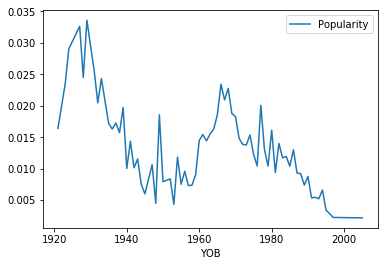

In [7]:
example.NamePopularityPlot("John", (1910,2010), "CA", "F")

Top 10 names that flipped:
Trinidad
    Cruz
  Michel
   Carey
   Kerry
 Carroll
   Sunny
  Shiloh
  Torrey
    Rian


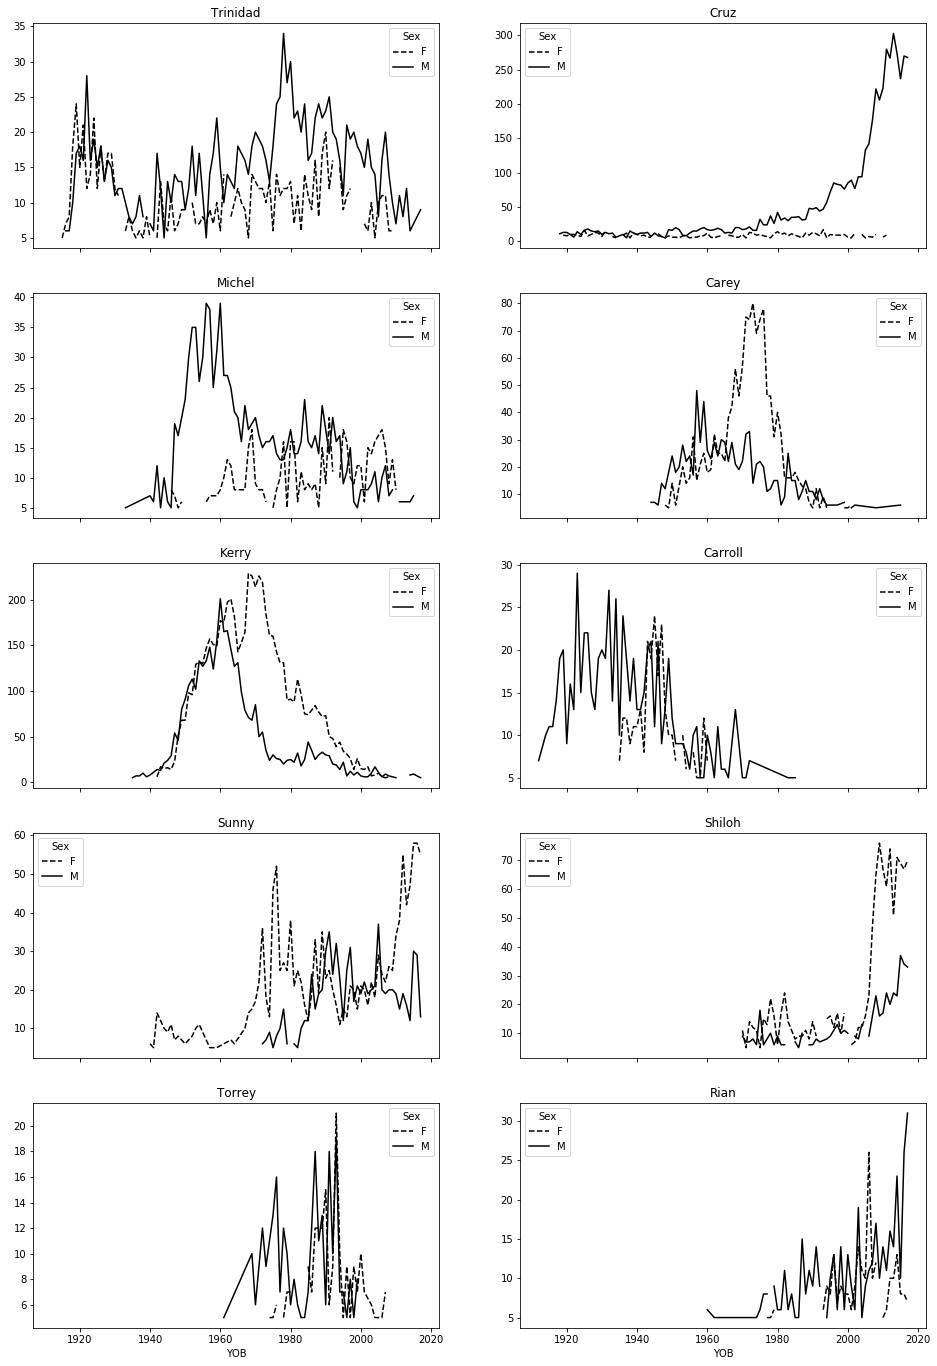

In [36]:
example.NameFlip()

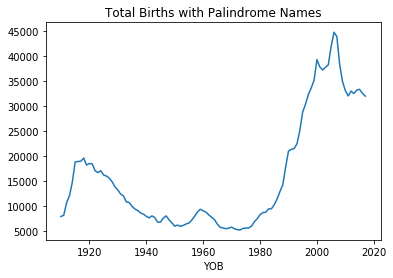

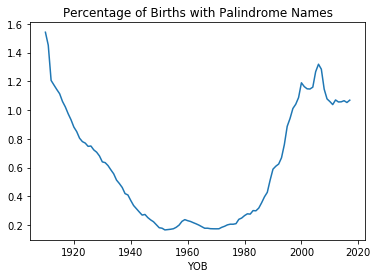

In [9]:
example.InterestingStory()